In [ ]:
!pip install roboflow

from roboflow import Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    

In [ ]:
rf = Roboflow(api_key="URIVAmnRmqDu9EEWx6go")
project = rf.workspace("plat-kendaraan").project("vehicle-and-license-plate")
version = project.version(3)
dataset = version.download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vehicle-and-license-plate-3 in tensorflow:: 100%|██████████| 5563/5563 [00:01<00:00, 4788.86it/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import SGD
from torch.optim import Adam
from torchvision.ops import nms

from PIL import Image, ImageDraw, ImageFont

<h1>Load Data<h1>

In [ ]:
class CarPlateDataset(Dataset):
    def __init__(self, df, image_dir, unique_img, indices, transform=None, test_mode=False, val_mode=False):
        self.df = df
        self.image_dir = image_dir
        self.unique_img = unique_img
        self.indices = indices
        self.transform = transform
        self.test_mode = test_mode
        self.val_mode = val_mode
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_img[self.indices[idx]]

        if self.test_mode:
            image_path = os.path.join(self.image_dir,"test", image_name)
        elif self.val_mode:
            image_path = os.path.join(self.image_dir,"valid", image_name)
        else:
            image_path = os.path.join(self.image_dir,"train", image_name)

        image = Image.open(image_path)
        boxes = self.df[self.df['filename'] == image_name].values[:, 4:].astype(float)
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = labels

        return transforms.ToTensor()(image), target


def custom_collate(data):
    return data

In [ ]:
Image_path = "vehicle-and-license-plate-3"

train_df = pd.read_csv("vehicle-and-license-plate-3/train/_annotations.csv")
val_df = pd.read_csv("vehicle-and-license-plate-3/valid/_annotations.csv")
test_df = pd.read_csv("vehicle-and-license-plate-3/test/_annotations.csv")

train_df = train_df[train_df['class'] == 'License_Plate']
train_unique = train_df.filename.unique()
train_indices = list(range(len(train_unique)))

val_df = val_df[val_df['class'] == 'License_Plate']
val_unique = val_df.filename.unique()
val_indices = list(range(len(val_unique)))

test_df = test_df[test_df['class'] == 'License_Plate']
test_unique = test_df.filename.unique()
test_indices = list(range(len(test_unique)))

In [ ]:
train_ds = CarPlateDataset(train_df, Image_path, train_unique, train_indices)
val_ds = CarPlateDataset(val_df, Image_path, val_unique, val_indices, val_mode=True)
test_ds = CarPlateDataset(test_df, Image_path, test_unique, test_indices, test_mode=True)

In [ ]:
BATCH_SIZE = 16

trainloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
valloader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
testloader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True, collate_fn=custom_collate)

<h1>Load Pretrained model<h1>

In [ ]:
def load_frcnn():
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    num_classes = 2
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=num_classes)

    return model

<h1>Training<h1>

In [ ]:
def train_model(epochs, model, optimizer, device, trainloader, valloader):
    # save the model with lowest validation loss
    best_valid_loss = float("inf")
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0

        for data in trainloader:
            imgs = []
            targets = []
            for d in data:
                imgs.append(d[0].to(device))
                targ = {}
                targ["boxes"] = d[1]["boxes"].to(device)
                targ["labels"] = d[1]["labels"].to(device)
                targets.append(targ)

            loss_dict = model(imgs, targets)
            torch.cuda.empty_cache()
            loss = sum(l for l in loss_dict.values())
            train_loss += loss.cpu().detach().numpy()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # get validation loss
        with torch.no_grad():
            for data in valloader:
                imgs = []
                targets = []
                for d in data:
                    imgs.append(d[0].to(device))
                    targ = {}
                    targ["boxes"] = d[1]["boxes"].to(device)
                    targ["labels"] = d[1]["labels"].to(device)
                    targets.append(targ)

                loss_dict = model(imgs, targets)
                torch.cuda.empty_cache()
                loss = sum(l for l in loss_dict.values())
                valid_loss += loss.cpu().detach().numpy()


        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "/kaggle/working/frcnn.pth")
        print(f"epoch: {epoch} | train_loss: {train_loss:.3f}, valid_loss: {valid_loss:.3f}")
    return best_valid_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model1 = load_frcnn()
model2 = load_frcnn()
models = [model1, model2]
lr_list = [0.01, 0.001]
valid_losses = []

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]


In [ ]:
models[0].to(device)
optimizer = SGD(models[0].parameters(), lr=lr_list[0], momentum=0.9, weight_decay=0.0005)
valid_loss = train_model(20, models[0], optimizer,device, trainloader, valloader)
valid_losses.append(valid_loss)
models[0].load_state_dict(torch.load("/kaggle/working/frcnn.pth"))
print("Best valid loss = ", valid_loss)

epoch: 0 | train_loss: 30.543, valid_loss: 1.909
epoch: 1 | train_loss: 18.505, valid_loss: 1.455
epoch: 2 | train_loss: 15.758, valid_loss: 1.271
epoch: 3 | train_loss: 13.279, valid_loss: 1.163
epoch: 4 | train_loss: 11.621, valid_loss: 1.127
epoch: 5 | train_loss: 10.394, valid_loss: 1.115
epoch: 6 | train_loss: 9.286, valid_loss: 1.014
epoch: 7 | train_loss: 8.141, valid_loss: 0.992
epoch: 8 | train_loss: 7.441, valid_loss: 1.092
epoch: 9 | train_loss: 7.104, valid_loss: 0.984
epoch: 10 | train_loss: 6.634, valid_loss: 0.937
epoch: 11 | train_loss: 6.290, valid_loss: 1.067
epoch: 12 | train_loss: 5.823, valid_loss: 0.918
epoch: 13 | train_loss: 5.501, valid_loss: 0.808
epoch: 14 | train_loss: 5.182, valid_loss: 0.852
epoch: 15 | train_loss: 5.178, valid_loss: 0.848
epoch: 16 | train_loss: 4.978, valid_loss: 0.769
epoch: 17 | train_loss: 4.880, valid_loss: 0.746
epoch: 18 | train_loss: 4.832, valid_loss: 0.861
epoch: 19 | train_loss: 4.584, valid_loss: 0.721
Best valid loss =  0.721

In [ ]:
models[1].to(device)
optimizer = SGD(models[1].parameters(), lr=lr_list[1], momentum=0.9, weight_decay=0.0005)
valid_loss = train_model(20, models[1], optimizer,device, trainloader, valloader)
valid_losses.append(valid_loss)
models[1].load_state_dict(torch.load("/kaggle/working/frcnn.pth"))
print("Best valid loss = ", valid_loss)

epoch: 0 | train_loss: 42.982, valid_loss: 2.325
epoch: 1 | train_loss: 25.084, valid_loss: 2.007
epoch: 2 | train_loss: 22.617, valid_loss: 1.879
epoch: 3 | train_loss: 21.541, valid_loss: 1.870
epoch: 4 | train_loss: 20.670, valid_loss: 1.708
epoch: 5 | train_loss: 19.897, valid_loss: 1.787
epoch: 6 | train_loss: 19.108, valid_loss: 1.795
epoch: 7 | train_loss: 18.448, valid_loss: 1.709
epoch: 8 | train_loss: 17.658, valid_loss: 1.622
epoch: 9 | train_loss: 17.100, valid_loss: 1.612
epoch: 10 | train_loss: 16.223, valid_loss: 1.564
epoch: 11 | train_loss: 15.633, valid_loss: 1.503
epoch: 12 | train_loss: 15.141, valid_loss: 1.514
epoch: 13 | train_loss: 14.275, valid_loss: 1.542
epoch: 14 | train_loss: 13.893, valid_loss: 1.433
epoch: 15 | train_loss: 13.264, valid_loss: 1.358
epoch: 16 | train_loss: 12.601, valid_loss: 1.382
epoch: 17 | train_loss: 12.128, valid_loss: 1.388
epoch: 18 | train_loss: 11.564, valid_loss: 1.321
epoch: 19 | train_loss: 11.126, valid_loss: 1.317
Best valid

In [ ]:
best_idx = valid_losses.index(min(valid_losses))
print("Best learning rate: ",lr_list[best_idx], " valid loss = ", valid_losses[best_idx])
best_model = models[best_idx]
torch.save(best_model.state_dict(), "/kaggle/working/frcnn.pth")

Best learning rate:  0.01  valid loss =  0.7214971631765366


<h1>Evaluation<h1>

In [ ]:
# load model
# best_model = load_frcnn()
# best_model.to(device)
# best_model.load_state_dict(torch.load("/kaggle/working/frcnn.pth"))

In [ ]:
!pip install pycocotools
import pycocotools
from torchmetrics.detection import MeanAveragePrecision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
best_model.eval()
targets = []
outputs = []
for idx in range(len(test_ds)):
    img, target = test_ds[idx]
    target["boxes"] = target["boxes"].to(device)
    target["labels"] = target["labels"].to(device)
    targets.append(target)
    with torch.no_grad():
        output = best_model([img.to(device)])
    outputs.append(output[0])


metric = MeanAveragePrecision(iou_type="bbox")
metric.update(outputs, targets)

In [ ]:
print(metric.compute())

{'map': tensor(0.9070), 'map_50': tensor(1.), 'map_75': tensor(1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.9126), 'map_large': tensor(0.8554), 'mar_1': tensor(0.8522), 'mar_10': tensor(0.9304), 'mar_100': tensor(0.9304), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.9350), 'mar_large': tensor(0.9000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


<h1>Sample Images<h1>

In [ ]:
def show_sample(model, dataset, idx):

    img,_ = dataset[idx]

    # get output from model
    model.eval()
    with torch.no_grad():
        output = model([img.to(device)])
    out_boxes = output[0]["boxes"]
    out_scores = output[0]["scores"]

    # perform nms to filter out some of the bounding boxes
    keep = nms(out_boxes, out_scores, 0.45)
    out_boxes = out_boxes[keep]
    out_scores = out_scores[keep]

    img = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')
    img = Image.fromarray(img)

    draw = ImageDraw.Draw(img)
    # predicted bb
    for box in out_boxes:
        draw.rectangle(list(box), fill=None, outline="red", width=2)

    return img, out_boxes

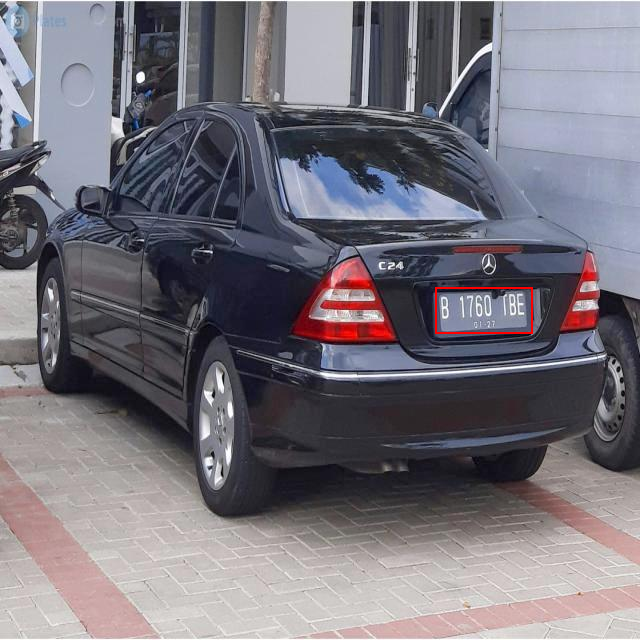

In [ ]:
index = 1
img, out_boxes = show_sample(best_model, test_ds, index)
img